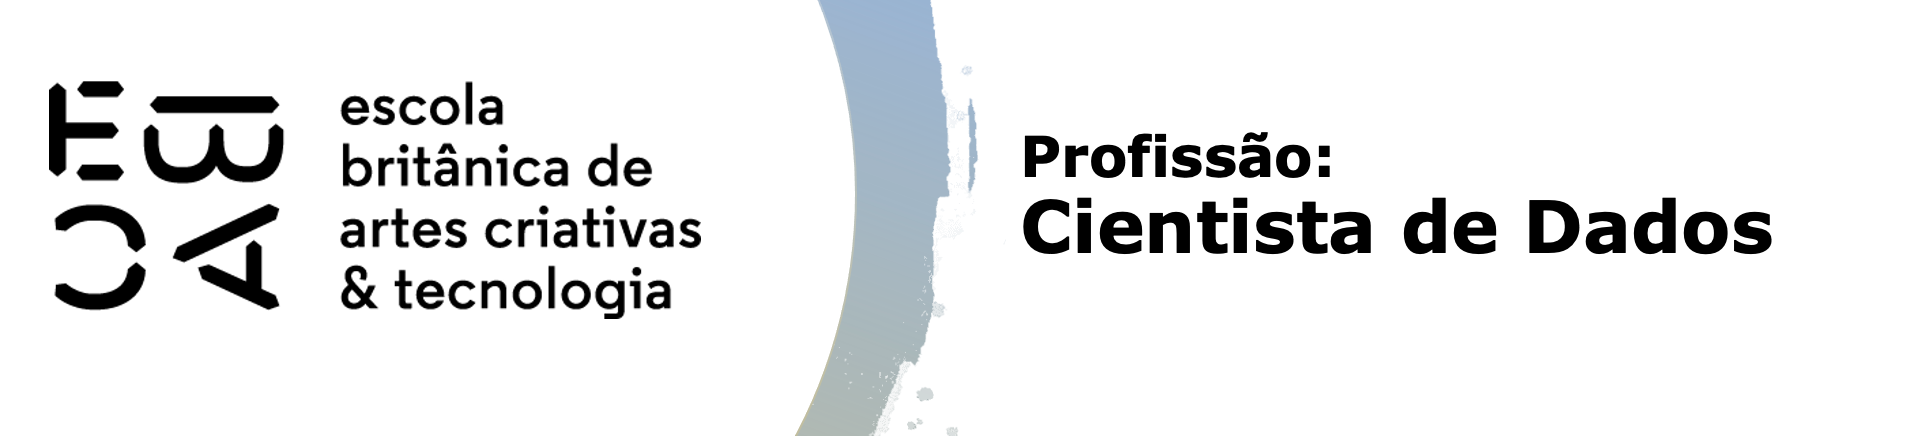

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

Verificar se os arquivos existem:
Arquivo y_train.txt: True
Arquivo y_test.txt: True
Arquivo X_train_subset.csv: True
Arquivo X_test_subset.csv: True


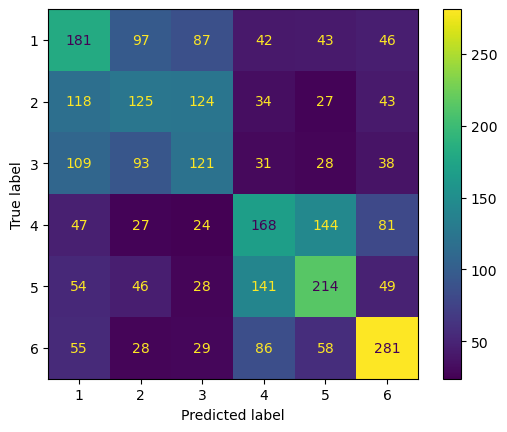

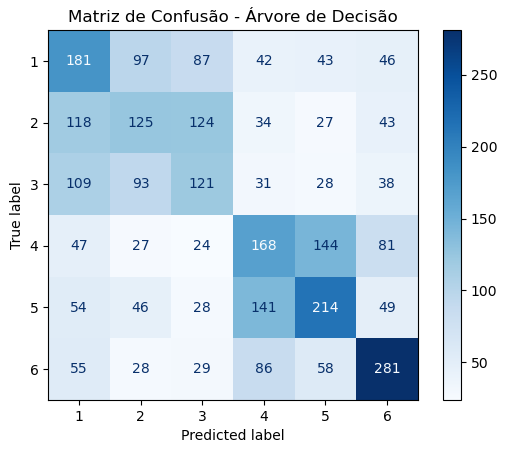

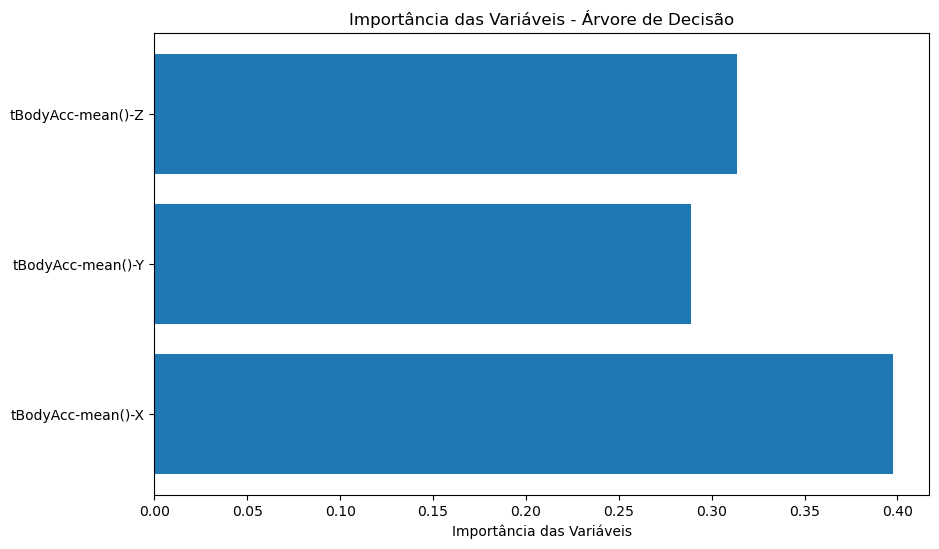

Acurácia no conjunto de treino: 1.0000
Acurácia no conjunto de teste: 0.3699


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import os

# Ajuste os caminhos conforme o local onde você salvou as bases de dados
dataset_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/UCI HAR Dataset/'

# Caminho dos arquivos CSV
csv_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/'

# Verificar se os arquivos realmente existem nos diretórios
print("Verificar se os arquivos existem:")
print(f"Arquivo y_train.txt: {os.path.exists(dataset_path + 'train/y_train.txt')}")
print(f"Arquivo y_test.txt: {os.path.exists(dataset_path + 'test/y_test.txt')}")
print(f"Arquivo X_train_subset.csv: {os.path.exists(csv_path + 'X_train_subset.csv')}")
print(f"Arquivo X_test_subset.csv: {os.path.exists(csv_path + 'X_test_subset.csv')}")

# Carregar as bases de dados (X_train, Y_train, X_test, Y_test)
X_train = pd.read_csv(csv_path + 'X_train_subset.csv', index_col=[0, 1])
Y_train = pd.read_csv(dataset_path + 'train/y_train.txt', header=None, names=["activity"]).squeeze()
X_test = pd.read_csv(csv_path + 'X_test_subset.csv', index_col=[0, 1])
Y_test = pd.read_csv(dataset_path + 'test/y_test.txt', header=None, names=["activity"]).squeeze()

# Treinar o modelo de árvore de decisão
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, Y_train)

# Avaliar o modelo com a matriz de confusão
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()

# Visualizar a importância das variáveis
feature_importances = model.feature_importances_

# Criar um gráfico de barras para visualizar a importância
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Importância das Variáveis")
plt.title("Importância das Variáveis - Árvore de Decisão")
plt.show()

# Avaliar a acurácia no conjunto de treino e teste
train_accuracy = model.score(X_train, Y_train)
test_accuracy = model.score(X_test, Y_test)

print(f"Acurácia no conjunto de treino: {train_accuracy:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")


### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

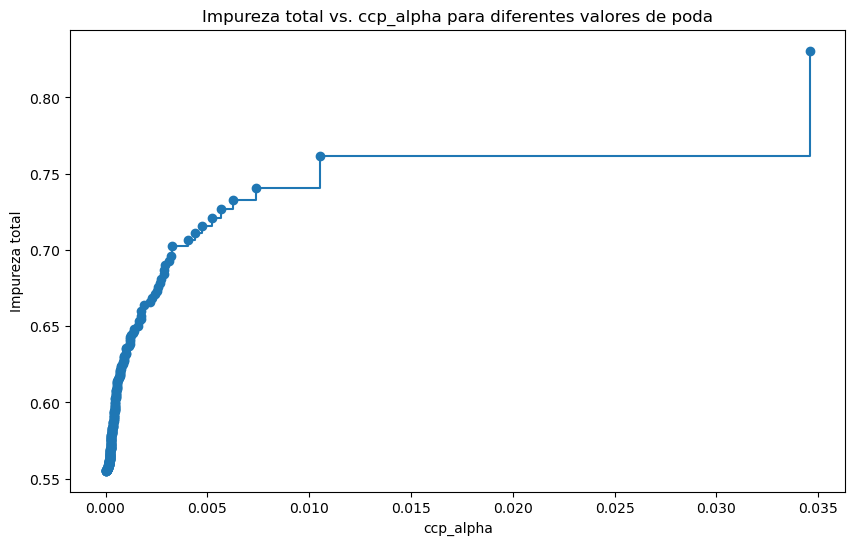

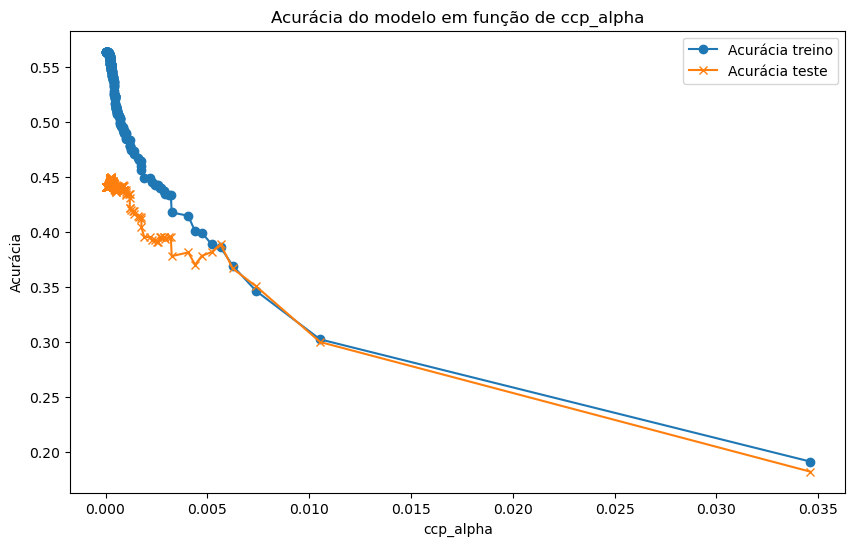

O melhor valor de ccp_alpha é: 0.000261784704614439
Acurácia final no conjunto de teste com o melhor ccp_alpha (0.000261784704614439): 0.4503


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Caminho dos arquivos CSV
csv_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/'

# Caminho dos arquivos TXT
dataset_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/UCI HAR Dataset/'

# Carregar as bases de dados (X_train, Y_train, X_test, Y_test)
X_train = pd.read_csv(csv_path + 'X_train_subset.csv', index_col=[0, 1])
Y_train = pd.read_csv(dataset_path + 'train/y_train.txt', header=None, names=["activity"]).squeeze()
X_test = pd.read_csv(csv_path + 'X_test_subset.csv', index_col=[0, 1])
Y_test = pd.read_csv(dataset_path + 'test/y_test.txt', header=None, names=["activity"]).squeeze()

# Inicializando a árvore de decisão
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)

# Treinando o modelo com o conjunto de treino
model.fit(X_train, Y_train)

# Extraindo os valores de ccp_alpha
path = model.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas  # Valores de ccp_alpha
impurities = path.impurities  # Impurezas para cada valor de ccp_alpha

# Plotando as impurezas para diferentes valores de ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Impureza total")
plt.title("Impureza total vs. ccp_alpha para diferentes valores de poda")
plt.show()

# Inicializando listas para armazenar a acurácia de treino e teste para cada ccp_alpha
train_accuracies = []
test_accuracies = []

# Avaliando a árvore para cada valor de ccp_alpha
for ccp_alpha in ccp_alphas:
    # Criando uma nova árvore com o valor de ccp_alpha
    tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, ccp_alpha=ccp_alpha)
    
    # Treinando a árvore
    tree.fit(X_train, Y_train)
    
    # Calculando a acurácia para o conjunto de treino e teste
    train_accuracies.append(tree.score(X_train, Y_train))
    test_accuracies.append(tree.score(X_test, Y_test))

# Plotando a acurácia no conjunto de treino e teste para cada ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_accuracies, marker="o", label="Acurácia treino")
plt.plot(ccp_alphas, test_accuracies, marker="x", label="Acurácia teste")
plt.xlabel("ccp_alpha")
plt.ylabel("Acurácia")
plt.title("Acurácia do modelo em função de ccp_alpha")
plt.legend()
plt.show()

# Encontrando o melhor ccp_alpha com base na acurácia do teste
best_ccp_alpha = ccp_alphas[np.argmax(test_accuracies)]
print(f"O melhor valor de ccp_alpha é: {best_ccp_alpha}")

# Criando a árvore final com o melhor ccp_alpha
best_tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, ccp_alpha=best_ccp_alpha)
best_tree.fit(X_train, Y_train)

# Avaliando o modelo final no conjunto de teste
final_test_accuracy = best_tree.score(X_test, Y_test)
print(f"Acurácia final no conjunto de teste com o melhor ccp_alpha ({best_ccp_alpha}): {final_test_accuracy:.4f}")


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [9]:
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score

# Caminho dos arquivos CSV
csv_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/'

# Caminho dos arquivos TXT
dataset_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/UCI HAR Dataset/'

# Carregar as bases de dados (X_train, Y_train, X_test, Y_test)
X_train = pd.read_csv(csv_path + 'X_train_subset.csv', index_col=[0, 1])
Y_train = pd.read_csv(dataset_path + 'train/y_train.txt', header=None, names=["activity"]).squeeze()
X_test = pd.read_csv(csv_path + 'X_test_subset.csv', index_col=[0, 1])
Y_test = pd.read_csv(dataset_path + 'test/y_test.txt', header=None, names=["activity"]).squeeze()

# Definir o modelo de árvore de decisão
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)

# Definir os valores de ccp_alpha para pesquisa no Grid Search
ccp_alphas = np.linspace(0, 0.02, 20)[::10]  # Escolher 1 a cada k valores, por exemplo k=10
param_grid = {'ccp_alpha': ccp_alphas}

# Configuração do GridSearchCV com 10-fold Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring=make_scorer(accuracy_score), n_jobs=-1)

# Medir o tempo de execução
start_time = time.time()

# Realizar o Grid Search
grid_search.fit(X_train, Y_train)

# Medir o tempo total de execução
end_time = time.time()
execution_time = end_time - start_time

# Exibir os resultados do Grid Search
print(f"Melhor valor de ccp_alpha: {grid_search.best_params_['ccp_alpha']}")
print(f"Melhor acurácia no conjunto de validação: {grid_search.best_score_:.4f}")
print(f"Tempo de execução do Grid Search: {execution_time:.2f} segundos")

# Avaliar a acurácia no conjunto de teste com o melhor modelo encontrado
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, Y_test)
print(f"Acurácia no conjunto de teste com o melhor modelo: {test_accuracy:.4f}")



Melhor valor de ccp_alpha: 0.0
Melhor acurácia no conjunto de validação: 0.4513
Tempo de execução do Grid Search: 8.94 segundos
Acurácia no conjunto de teste com o melhor modelo: 0.4408


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia no conjunto de teste com o melhor modelo: 0.4408


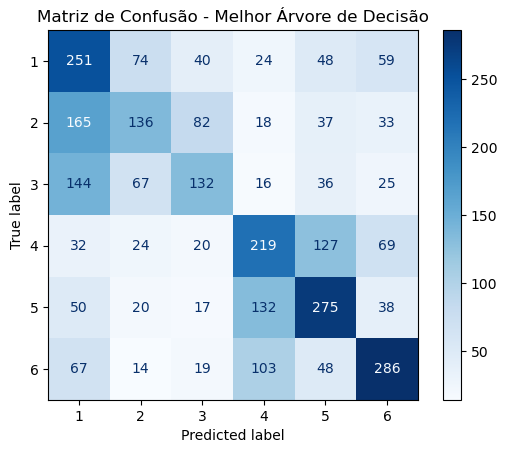

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Caminho dos arquivos CSV
csv_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/'

# Caminho dos arquivos TXT
dataset_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/UCI HAR Dataset/'

# Carregar as bases de dados (X_train, Y_train, X_test, Y_test)
X_train = pd.read_csv(csv_path + 'X_train_subset.csv', index_col=[0, 1])
Y_train = pd.read_csv(dataset_path + 'train/y_train.txt', header=None, names=["activity"]).squeeze()
X_test = pd.read_csv(csv_path + 'X_test_subset.csv', index_col=[0, 1])
Y_test = pd.read_csv(dataset_path + 'test/y_test.txt', header=None, names=["activity"]).squeeze()

# Usando o melhor modelo do GridSearchCV
best_model = grid_search.best_estimator_

# Treinar o modelo na base de treino completa
best_model.fit(X_train, Y_train)

# Calcular a acurácia no conjunto de teste
test_accuracy = best_model.score(X_test, Y_test)
print(f"Acurácia no conjunto de teste com o melhor modelo: {test_accuracy:.4f}")

# Gerar a matriz de confusão
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(Y_test, y_pred)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Melhor Árvore de Decisão")
plt.show()


### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia